Written by **Matt Mortimer** <br />
Contributions by Matt Spence (see specific scripts)<br />
started 26 Oct 2021<br />
matthew.mortimer@anu.edu.au<br />
Orcid ID: https://orcid.org/0000-0002-8135-9319<br />
Python 3<br />


# Overview - KRAB Domain project
**Background:** <br />
Engineering KRAB domain <br />
**Aim:** <br />
 component of the project aims to generate a KRAB Domain phlyogeny and reconstruct the ancestors <br /> 
**Data sources:**  <br />
PFAM (PF01532)

**Dependencies:**<br />
1.    Biopython
2.    BioServices
3.    Pandas
4.    Seaborn

**Custom module versions**<br />
1. analysis v2.1.0
2. annotations v1.3.1
3. cleaner v1.3.2
4. log v1.2.0
5. progress v1.0.1 
6. run_blast v1.1.1
7. size_filter v1.0.3
8. uniprot v1.0.2
9. utilities v1.0.0

In [1]:
import pandas as pd

# Custom scripts
from modules.annotations import *
from modules.cleaner import *
from modules.analysis import len_distro
from modules.run_blast import blast
from modules.size_filter import *
from modules.uniprot import uniprot
from modules.utilities import *

# Processing PFAM, unalined, sequence list

Downloaded the sequences as a single, unaligned, fasta file from the PFAM website with 30,630 sequences of ~42 residues in length, saved in project file as 'PF01352_full.txt'
Using BioServices to download from uniprot provides full length sequences, complicating alignment. 
In working directory I created two folders 'input' and 'output'. Placed sequence list into 'input'. 
Save and run this notebook from the working directory with the following custom functions:
annotations
indexing
len_distro
log
run_blast
sequence_cleaner
size filter

In [2]:
# Set constant variables for this notebook

date = datetime.now().strftime('%y%m%d')
PROJECT = 'KRAB'

# Check working dir
import pathlib
print(pathlib.Path().resolve())

C:\Users\mattm\Desktop\Nourish_projects\Phylogenetics-ASR


# Sequence assessment and cleaning

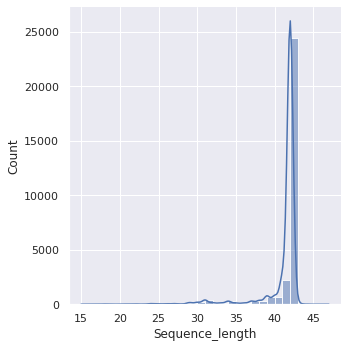

In [3]:
# Take the outputted file from above and pass to len_distro which will provide a 
# seaborn displot, can add bin width and, x and y size as arguments if necessary. 
# This function is used to assess size distrobution of sequences which can be 
# filtered if necessary

# Here I've used a binwidth of 1

len_distro(f'input/PF01352_full.txt', 1)

In [4]:
# This function takes a fasta file, project name, data source as arguments. 
# Stiplute 'greater' or 'less' and the length in resiudes as arguments to 
# filter out others that do not meet that condition. 

# Here I've retained sequences of > than 39 residues in length, discarding 
# the rest.   

size_filter(f'input/PF01352_full.txt', PROJECT, 'PFAM', 'greater', 39)

Seqeunces from input/PF01352_full.txt were filtered to those greater than 39 aa
27542 filtered sequences were outputed to "output/211119_KRAB_PFAM_size_filt.fasta"


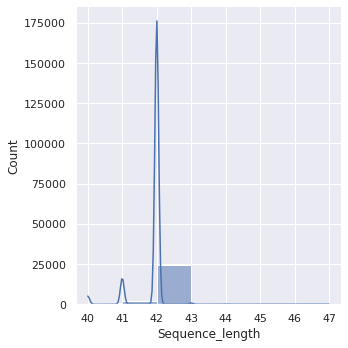

In [5]:
# Double check the filtering by passing the output from 'size_filter' 
# function back to the len_distro function. 

len_distro(f'output/{date}_KRAB_PFAM_size_filt.fasta', 1)

In [6]:
# This function pulls back the UniProt annotations for the sequences 
# filtered by size. Takes 3 arguments, the input file, the data source
# and the project name. Generates a text file in tab seperated csv format

# This function takes a very long time to run, each sequence must be 
# individually passed back to the served and then wait for the reply, 
# sequentially. 

input_f = f'output/{date}_KRAB_PFAM_size_filt.fasta'

annotations(input_f, 'PFAM', PROJECT, delim="_", el_num=0)

Percent compelete: [##------------------] 9.07%  Estimated time left 165.79 min IndexError: Annotation doesn't match expected format
Last annotation was:
Accession: 
Sequence number : 2497
Percent compelete: [####################] 100.00%  Estimated time left 0.01 min Run time: 2:56:42 hh:mm:ss
Annotations were retrieved or attempted for 27541 sequences from output/211119_KRAB_PFAM_size_filt.fasta and outputted to 'output/211119_KRAB_PFAM_filt_annotations.txt'


In [3]:
# This indexing function takes the annotation file generated above and 
# the last generated fasta file then adds the sequence to the annotations
# and generates a 'master index' csv file. This can act a reference going 
# forward and a repository of un-edited sequences.

# The function takes 3 arguments, the annotation text file generated from 
# the annotations function, a related fasta file, and the project name. 

# The function works by merging pandas dataframes as 'inner' on the 'Entry'
# name, so if a sequence Entry name is missing from the annotation file
# that sequence is lost.

annotation_file = f'{PROJECT}/output/{date}_PFAM_filt_annotations.txt'
sequence_file = f'{PROJECT}/output/{date}_PFAM_size_filt.fasta'

indexing(annotation_file, sequence_file, PROJECT, delim="_", el_num=0)

Master index containing annotation and sequence data created with 0 records.
Outputtted file called 'KRAB/output/211207_PFAM_master_index.csv'


In [5]:
# This code is not appropriate for a seqperate function and will likely 
# need to be edited on a case-by-case basis. It takes the master index 
# and filters by row value on a column then generates a new fasta file.
# In this case a number of the proteins are listed as 'Deleted.' and 
# I have removed them from the dataset with this codes. 

# Uses pandas to generate a dataframe (df)
index_df = pd.read_csv(f'{PROJECT}/output/{date}_PFAM_master_index.csv')
# Creates a new dataframe except for records with 'Deleted.' in the
# column 'Protein names'
index_df2 = index_df[index_df['Protein names']!= 'Deleted.']

# Variable with the name of the outputted fasta file
output_file = f'{PROJECT}/output/{date}_index_filt.csv'

# Writes to file 
index_df2.to_csv(output_file, sep=",", index=False)

# Assigns the length of fasta_dict to seq_num
seq_num = len(index_df2)

# Prints and logs summary 
print(f"Number of sequences in '{output_file}': {seq_num}")
log(f"{output_file} created with {seq_num} sequences filtered by column \
    'Protein names' != 'Deleted.'")

KeyError: 'Protein names'

In [9]:
# We need to filter out the duplicate sequences, however if one of the
# copies has Status 'reviewed' we need to keep that copy not the 
# unreviewed one. To do this we need to split the dataset into
# reivewed and unreviewed sequences, remove duplicates from within
# those subsets before remove duplicates between the subsets
index_file = 'output/211119_KRAB_index_filt.csv'

reviewed(index_file, 'KRAB')

There are 1 reviewed sequences in the dataset
There are 26661 unreviewed sequences in the dataset
1 sequences were written to output/211119_KRAB_reviewed.fasta
26661 sequences were written to output/211119_KRAB_unreviewed.fasta


In [10]:
# Takes the fasta files generated above and passes them seperately to the
# sequence_cleaner function, with datasource and project name as arguments. 
# Removes duplicate sequences, and sequences with ambigious residues. 
# There maybe duplications between the two files however 

cleaner(f'output/{DATE}_{PROJECT}_reviewed.fasta', 'PFAM_reviewed', PROJECT)

print('') # Just makes the output easier to read

cleaner(f'output/{DATE}_{PROJECT}_unreviewed.fasta', 'PFAM_unreviewed', PROJECT)

1 were kept, output was written to 211119_KRAB_PFAM_reviewed_cleaned.fasta. 0 sequences were dropped and written to output/211119_KRAB_PFAM_reviewed_cleaner_dropped_seq.fasta
There were 0 instances of duplicate or ambiguous sequences.
output/211119_KRAB_PFAM_reviewed_cleaned.fasta

11572 were kept, output was written to 211119_KRAB_PFAM_unreviewed_cleaned.fasta. 3809 sequences were dropped and written to output/211119_KRAB_PFAM_unreviewed_cleaner_dropped_seq.fasta
There were 14488 instances of duplicate or ambiguous sequences.
output/211119_KRAB_PFAM_unreviewed_cleaned.fasta


In [11]:
reviewed_file = f'output/{date}_{PROJECT}_PFAM_reviewed_cleaned.fasta'
unreviewed_file = f'output/{date}_{PROJECT}_PFAM_unreviewed_cleaned.fasta'

reviewed_unreviewed(reviewed_file, unreviewed_file, 'PFAM', PROJECT)

11573 sequences were kept, output was written to 211119_KRAB_PFAM_rev_unrev_deduped.fasta. 0 sequences were dropped and written to output/test_joint_cleaned_cleaner_dropped_seq.fasta

output/211119_KRAB_PFAM_rev_unrev_deduped.fasta


Make sure the seed sequence is still in the dataset, otherwise add it in either manually or using code. If added in make sure that is clear in the annotation.

We only add it back in in order to help ensure that we isolate the correct clusted later on when we visulise the SSN

# Generate Network file using blast

In [12]:
# Run a all v all BLAST search using a blast function 
# BLAST must be installed locally.
# Takes 3 arguments, a fasta file, and the project name.

# Just a clear way of laying out the function arguments

in_fasta = 'output/211119_KRAB_PFAM_rev_unrev_deduped.fasta' # Use the last outputted 
                                                        # fasta file from above
# path = '/usr/lib/ncbi-blast-2.12.0+/bin'

# Actual BLAST function, using default E_value_threshold="10e-10", cpus="2" (adjust 
# these arguments as required)

blast(in_fasta, PROJECT, '10e-10', cpus='30')

Run time: 0:04:51 hh:mm:ss
Network file output/BLAST/211119_KRAB_dataset_network_10e-10.csv generated


# Merge the network file with the taxonomic data

In [13]:
# Set input and output files as variables 
input_network = 'output/BLAST/211119_KRAB_dataset_network_10e-10.csv'
input_index = 'output/211119_KRAB_index_filt.csv'
output_network = 'output/BLAST/211119_KRAB_SSN_10e-10.csv'

# Read the input files
netwrk = pd.read_csv(input_network)
master_index = pd.read_csv(input_index)

# Make a new dataframe for the input_files with a subset of columns, then rename
# the first column of the input_network dataframe so that it can be easily merged 
# with the index file
nw_mod = netwrk[['Query', 'Target', '% Identity', 'Length', 'E-value', 'Bit-score']]
nw_mod.columns = ['Entry', 'Target', '% Identity', 'Length', 'E-value', 'Bit-score']

index = master_index[['Entry', 'Status', 'Protein names', 'Gene names', 'Organism']]

In [14]:
# Check the dataframe
nw_mod.head()

,Entry,Target,% Identity,Length,E-value,Bit-score
0,Q8CF60,Q8CF60,100.000,40,7.280000e-26,84.3
1,Q8CF60,A0A1A6HXD6,87.500,40,1.080000e-21,73.6
2,Q8CF60,D3ZQ68,90.000,40,6.280000e-21,71.6
3,Q8CF60,G3I038,84.615,39,9.510000e-21,71.2
4,Q8CF60,F6YG67,82.500,40,2.330000e-19,67.8


In [15]:
# Check the dataframe
index.head()

,Entry,Status,Protein names,Gene names,Organism
0,A0A2K6SFI0,unreviewed,Zinc finger protein 182,ZNF182,Saimiri boliviensis boliviensis (Bolivian squi...
1,A0A2K6Q1Z0,unreviewed,Uncharacterized protein,ZNF721,Rhinopithecus roxellana (Golden snub-nosed mon...
2,A0A2U3V9T7,unreviewed,zinc finger protein 699 isoform X1,LOC101333634,Tursiops truncatus (Atlantic bottle-nosed dolp...
3,A0A452C367,unreviewed,zinc finger protein 852 isoform X2,ZNF852,Balaenoptera acutorostrata scammoni (North Pac...
4,A0A4W2CM52,unreviewed,Zinc finger protein 214,ZNF214,Bos indicus x Bos taurus (Hybrid cattle)


In [16]:
# Merge the dataframes on the Entry column. This will add the 
# taxonomic information to the network file
merged = nw_mod.merge(index, on='Entry', how='left')

In [17]:
# Check the dataframe, didn't use .head() as need to see the 
# last rows.
merged

,Entry,Target,% Identity,Length,E-value,Bit-score,Status,Protein names,Gene names,Organism
0,Q8CF60,Q8CF60,100.000,40,7.280000e-26,84.3,reviewed,Zinc finger protein 263 (Zinc finger protein F...,Znf263 FPM315 Zfp263 ZKSCAN12,Mus musculus (Mouse)
1,Q8CF60,A0A1A6HXD6,87.500,40,1.080000e-21,73.6,reviewed,Zinc finger protein 263 (Zinc finger protein F...,Znf263 FPM315 Zfp263 ZKSCAN12,Mus musculus (Mouse)
2,Q8CF60,D3ZQ68,90.000,40,6.280000e-21,71.6,reviewed,Zinc finger protein 263 (Zinc finger protein F...,Znf263 FPM315 Zfp263 ZKSCAN12,Mus musculus (Mouse)
3,Q8CF60,G3I038,84.615,39,9.510000e-21,71.2,reviewed,Zinc finger protein 263 (Zinc finger protein F...,Znf263 FPM315 Zfp263 ZKSCAN12,Mus musculus (Mouse)
4,Q8CF60,F6YG67,82.500,40,2.330000e-19,67.8,reviewed,Zinc finger protein 263 (Zinc finger protein F...,Znf263 FPM315 Zfp263 ZKSCAN12,Mus musculus (Mouse)
...,...,...,...,...,...,...,...,...,...,...
5803769,H0XF31,G3VJ09,54.762,42,5.820000e-13,51.6,unreviewed,Zinc finger with KRAB and SCAN domains 1,ZKSCAN1,Otolemur garnettii (Small-eared galago) (Garne...
5803770,H0XF31,A0A2Y9RP57,48.649,37,2.280000e-10,45.1,unreviewed,Zinc finger with KRAB and SCAN domains 1,ZKSCAN1,Otolemur garnettii (Small-eared galago) (Garne...
5803771,H0XF31,A0A212CY96,50.000,44,3.540000e-10,44.7,unreviewed,Zinc finger with KRAB and SCAN domains 1,ZKSCAN1,Otolemur garnettii (Small-eared galago) (Garne...
5803772,H0XF31,A0A673UBJ6,50.000,42,5.970000e-10,44.3,unreviewed,Zinc finger with KRAB and SCAN domains 1,ZKSCAN1,Otolemur garnettii (Small-eared galago) (Garne...


In [18]:
# Write the new network dataframe to file
merged.to_csv(output_network, index=False)